# Clustering of PBMC with cell annotations from Azimuth reference labeling 

- comparing control versus depleted and highlighting any differences in annotation 

In [1]:
import scanpy as sc
import pegasus as pg
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from pegasus.tools import largest_variance_from_random_matrix
import scanpy.external as sce

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/utils.py:429: 

/Users/jbezney/opt/anaconda3/envs/pegasus2/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_65744/3490392073.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs['batch'] = 'scCLEAN'


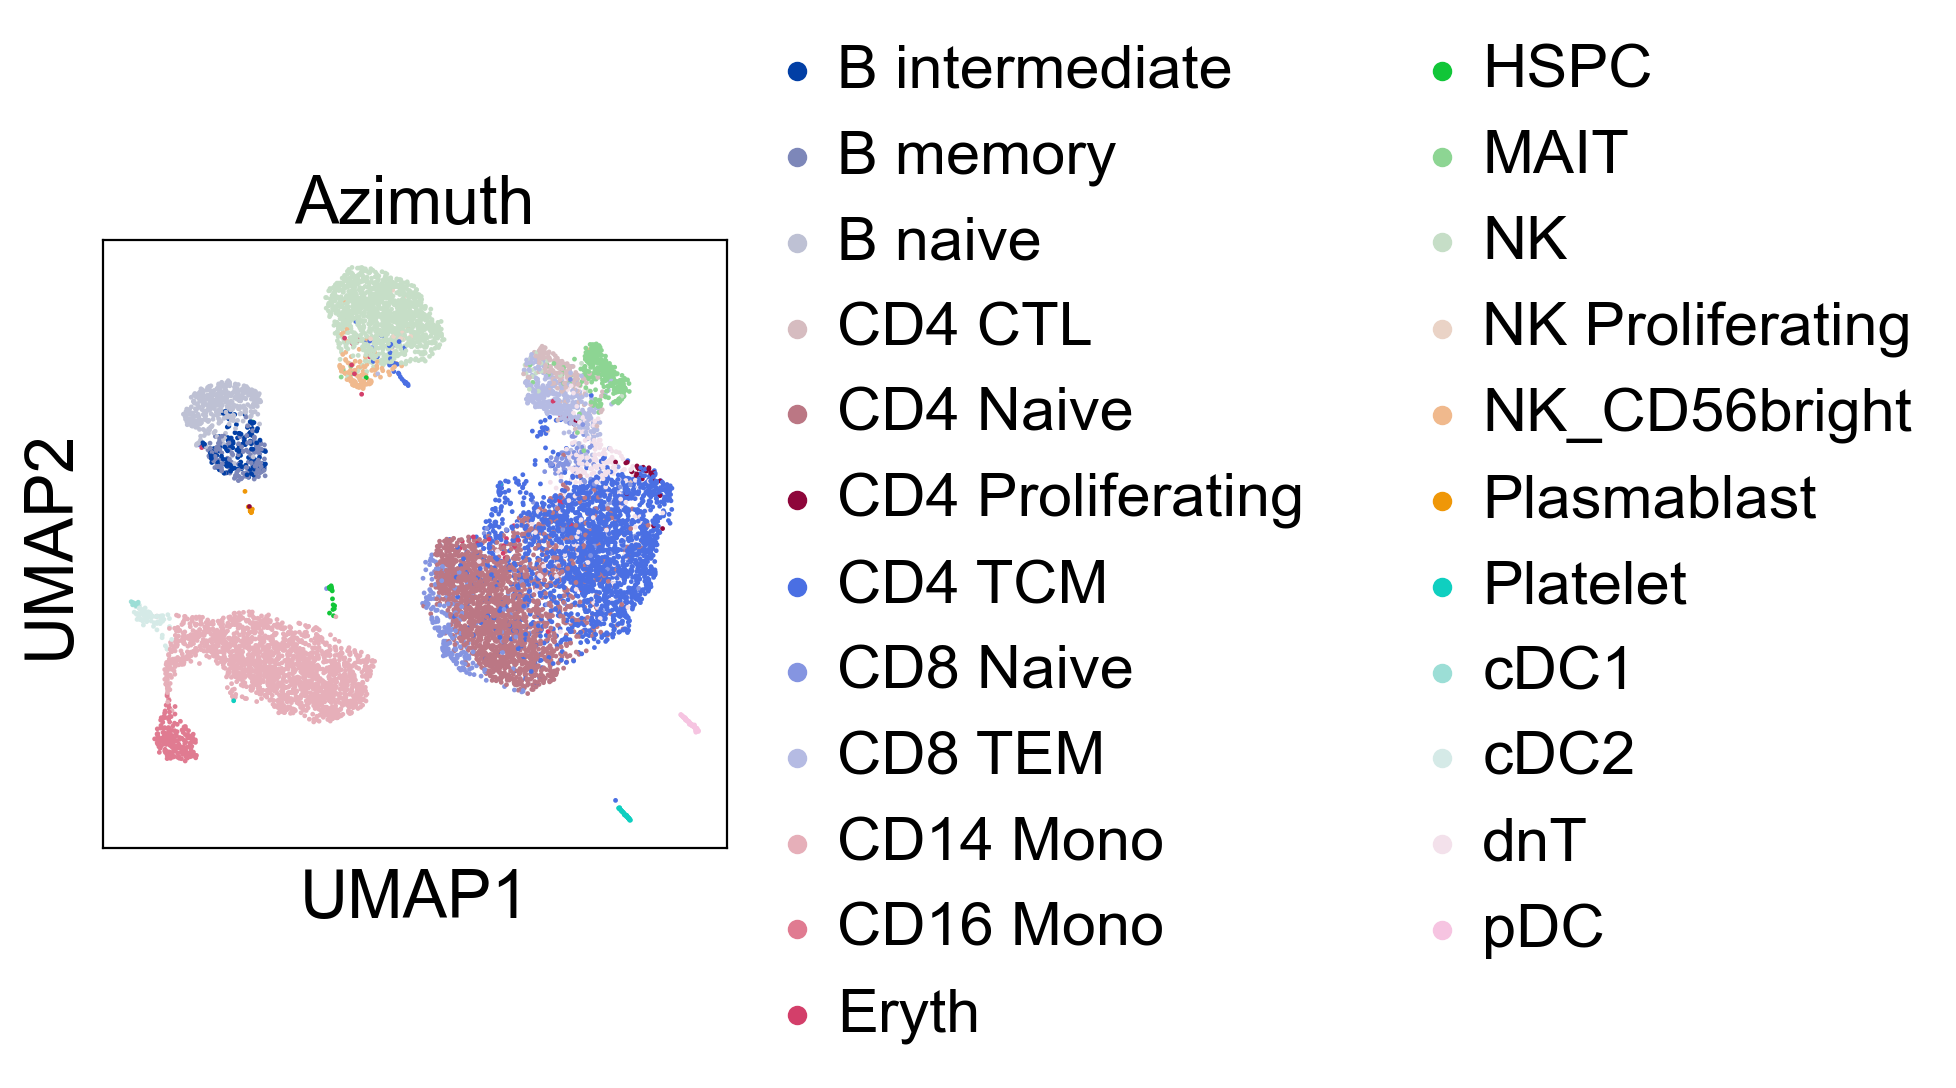

In [7]:
#depleted
data = sc.read_10x_h5('raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5')
data.var_names_make_unique()
#remove the cells that are not incorporated into the full dataset
#bring in the annotations from Azimuth reference labeling 
annotations = pd.read_csv('Azimuth_annotations/depleted_cell_labels.csv')
anno_list = list(annotations['Unnamed: 0'])
barcode=[]
rep = []
for label in anno_list:
    name1,name2,name3 = label.split('_')
    barcode.append(name3)
    rep.append(name2)
annotations['rep'] = rep
annotations['barcode'] = barcode
annotations = annotations[annotations['rep']=='rep2']
annotations = annotations.set_index('barcode')

#add the labels to the anndata and remove unlabeled (previously filtered)
data.obs['Azimuth'] = annotations['identities_depleted']
cell_types = list(data.obs['Azimuth'].unique())
cell_types = [x for x in cell_types if str(x) != 'nan']
data = data[data.obs['Azimuth'].isin(cell_types)]

#set the batch 
data.obs['batch'] = 'scCLEAN'
data = data.copy()

#cells have already been filtered using miQC
sc.pp.filter_genes(data, min_cells=5)
sc.pp.calculate_qc_metrics(data, inplace=True)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_mean=0.01, min_disp=0.2)
sc.tl.pca(data)

#use random matrix theory to determine the proper number of PCs to use
nfeatures = data.var['highly_variable'].sum()
thre = largest_variance_from_random_matrix(data.shape[0], nfeatures, '0.05')
ncomps_dep = (data.uns['pca']["variance"] > thre).sum()
sc.pp.neighbors(data, n_neighbors=15, n_pcs=ncomps_dep)

#use PAGA to initialize the UMAP embedding
sc.tl.paga(data, groups='Azimuth')
sc.pl.paga(data, plot=False)
sc.tl.umap(data, init_pos='paga')
sc.pl.umap(data, color='Azimuth')

/Users/jbezney/opt/anaconda3/envs/pegasus2/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_27989/3301431091.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['batch'] = '10x-V3'


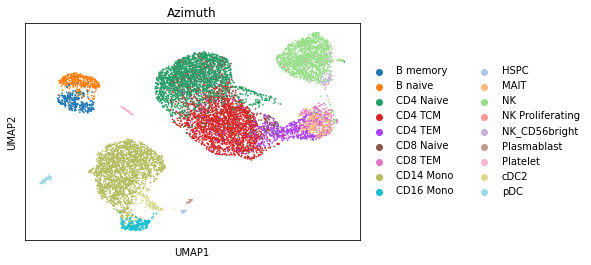

In [2]:
#standard
adata = sc.read_10x_h5('raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
#remove the cells that are not incorporated into the full dataset
#bring in the annotations from Azimuth reference labeling 
annotations = pd.read_csv('Azimuth_annotations/control_cell_labels.csv')
anno_list = list(annotations['Unnamed: 0'])
barcode=[]
rep = []
for label in anno_list:
    name1,name2,name3 = label.split('_')
    barcode.append(name3)
    rep.append(name2)
annotations['rep'] = rep
annotations['barcode'] = barcode
annotations = annotations[annotations['rep']=='rep2']
annotations = annotations.set_index('barcode')

#add the labels to the anndata and remove unlabeled (previously filtered)
adata.obs['Azimuth'] = annotations['identities_control']
cell_types = list(adata.obs['Azimuth'].unique())
cell_types = [x for x in cell_types if str(x) != 'nan']
adata = adata[adata.obs['Azimuth'].isin(cell_types)]

#set the batch 
adata.obs['batch'] = '10x-V3'
#rename 56 bright to CD56 bright to match the previous naming
adata.obs['Azimuth'] = adata.obs['Azimuth'].replace('NK_56bright','NK_CD56bright')
adata = adata.copy()

#cells have already been filtered using miQC
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.01, min_disp=0.2)
sc.tl.pca(adata)

#use random matrix theory to determine the proper number of PCs to use
nfeatures = adata.var['highly_variable'].sum()
thre = largest_variance_from_random_matrix(adata.shape[0], nfeatures, '0.05')
ncomps = (adata.uns['pca']["variance"] > thre).sum()
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=ncomps)

#use PAGA to initialize the UMAP embedding
sc.tl.paga(adata, groups='Azimuth')
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color='Azimuth')


In [3]:
adata

AnnData object with n_obs × n_vars = 10184 × 19509
    obs: 'Azimuth', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'paga', 'Azimuth_sizes', 'umap', 'Azimuth_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

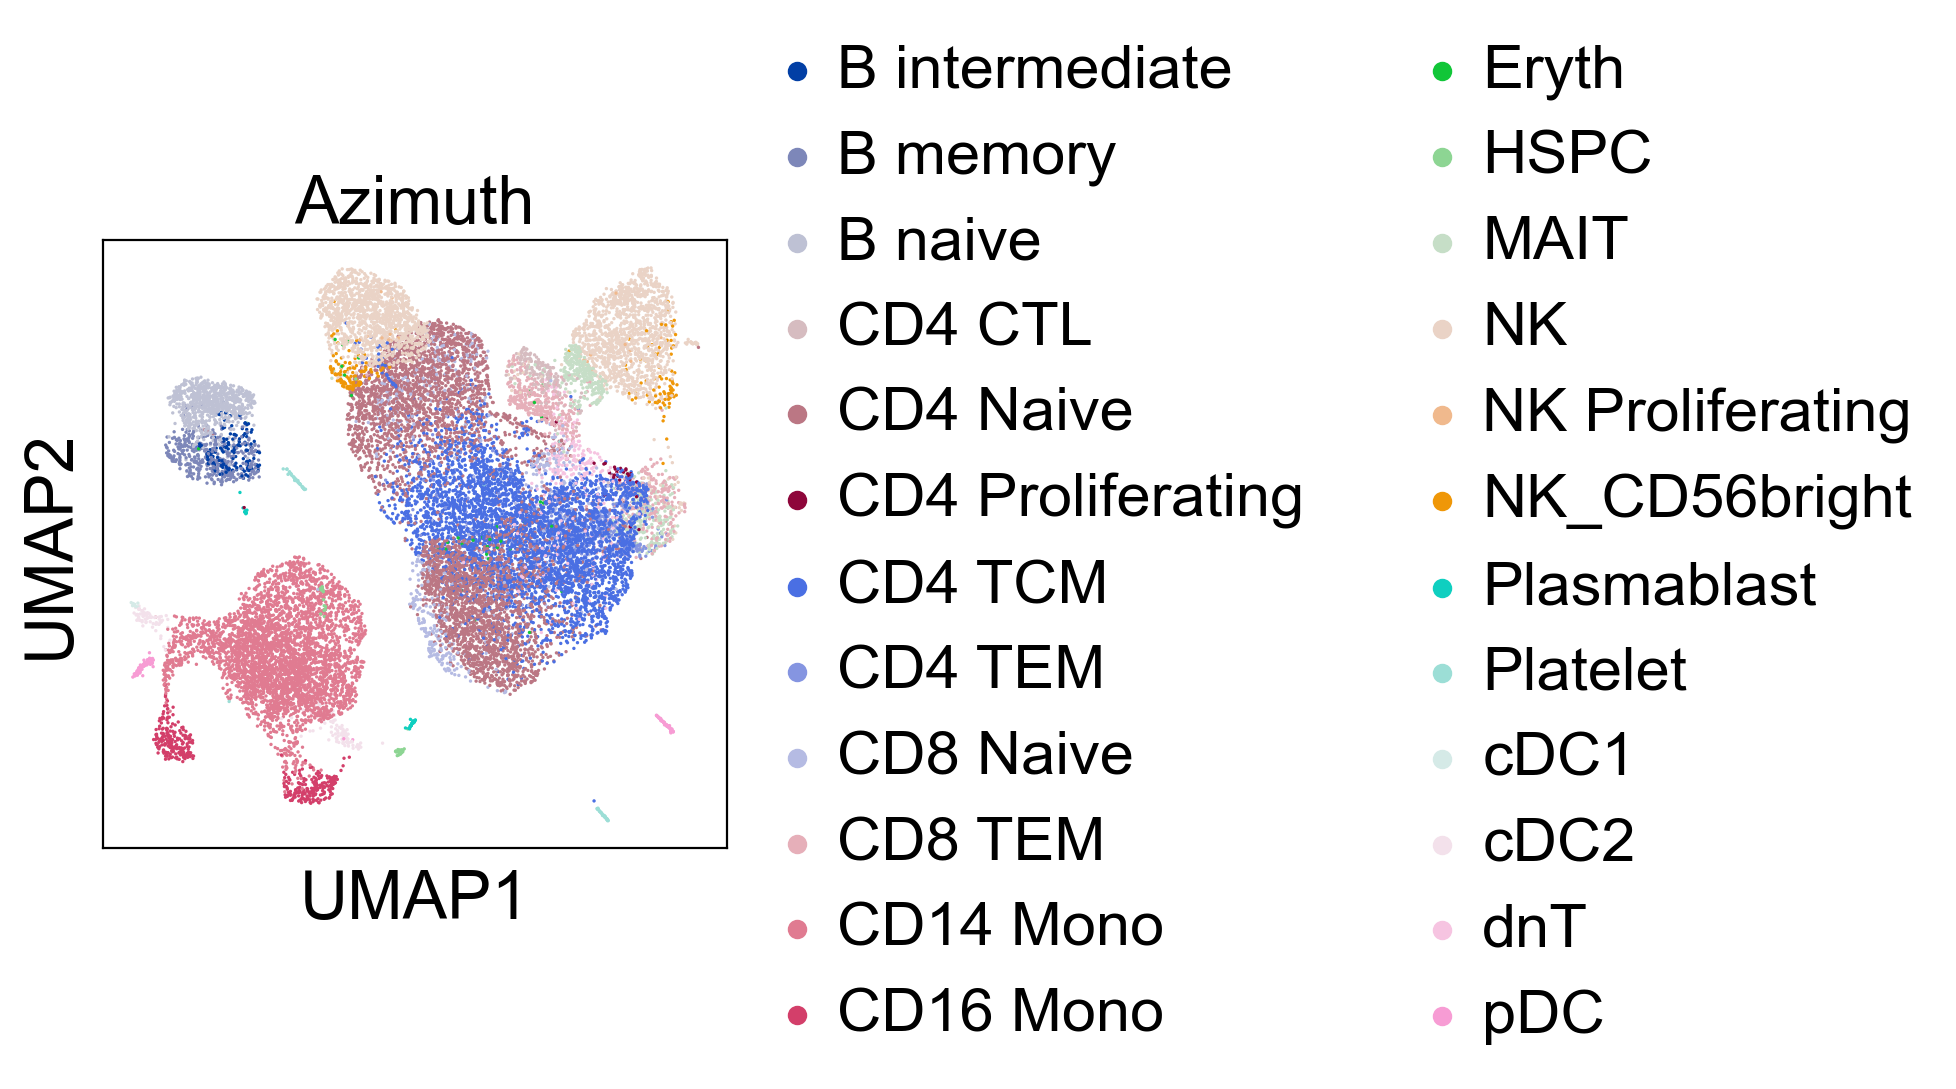

In [9]:
#combine dataframes to get the same colors
merged = adata.concatenate(data)
sc.pl.umap(merged, color='Azimuth')

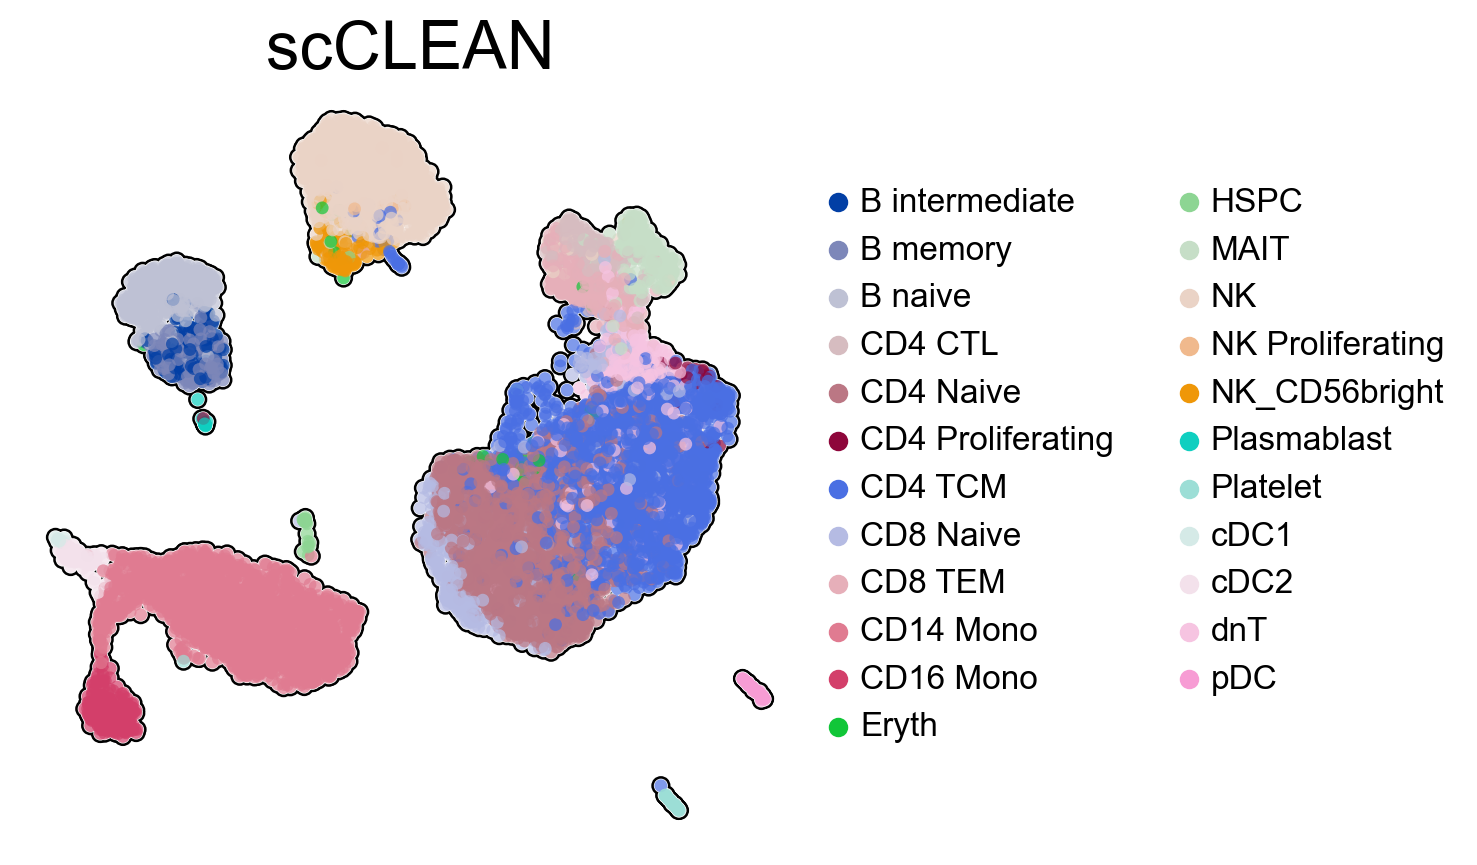

In [10]:
#split into scCLEAN and plot
data = merged[merged.obs['batch']=='1']
#data.obsm['X_umap'] = data.obsm['X_umap_harmony']

from matplotlib.pyplot import rc_context
sc.set_figure_params(scanpy=True, fontsize=24, dpi=100, dpi_save=300)
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.umap(data,color=['Azimuth'], legend_loc='right margin',alpha=0.7,
                     legend_fontsize=12, legend_fontoutline=2,frameon=False, title=f'scCLEAN', 
                     size=85, return_fig=False, add_outline=True, outline_width=(0.2, 0.05),
                     save='PBMC_scCLEAN_Azimuth.png')

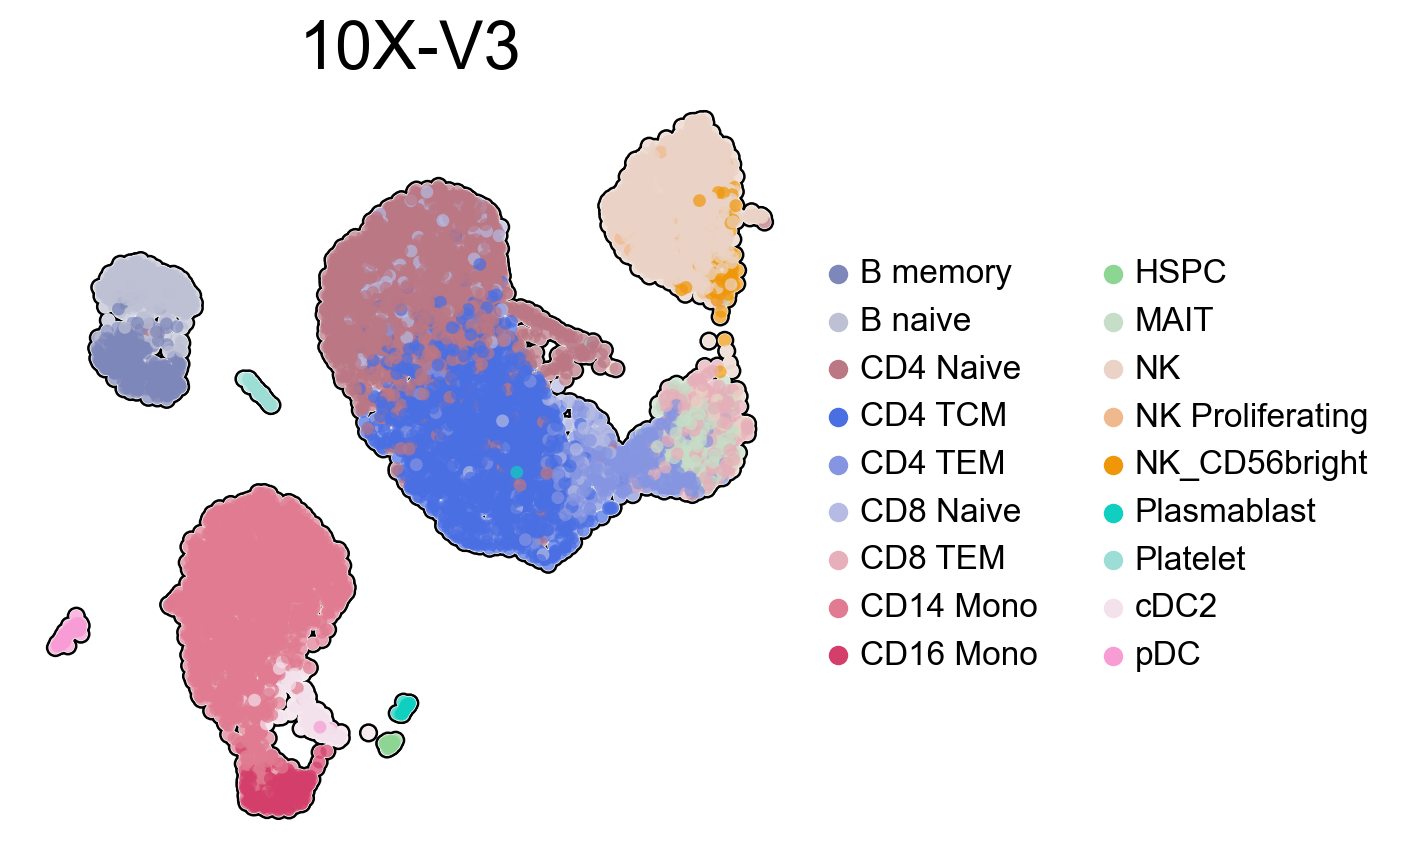

In [11]:
#split into 10X-V3 and plot
adata = merged[merged.obs['batch']=='0']
#adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']

from matplotlib.pyplot import rc_context
sc.set_figure_params(scanpy=True, fontsize=24, dpi=100, dpi_save=300)
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.umap(adata,color=['Azimuth'], legend_loc='right margin',alpha=0.7,
                     legend_fontsize=12, legend_fontoutline=2,frameon=False, title=f'10X-V3', 
                     size=85, return_fig=False, add_outline=True, outline_width=(0.2, 0.05),
                     save='PBMC_10xv3_Azimuth.png')


In [164]:
#find the cell clusters unique to each dataset
standard_cells = list(adata.obs['Azimuth'].unique())
depleted_cells = list(data.obs['Azimuth'].unique())
unique_10x = []
unique_scCLEAN = []
for cell in standard_cells:
    if cell not in depleted_cells:
        unique_10x.append(cell)
for cell in depleted_cells:
    if cell not in standard_cells:
        unique_scCLEAN.append(cell)
        

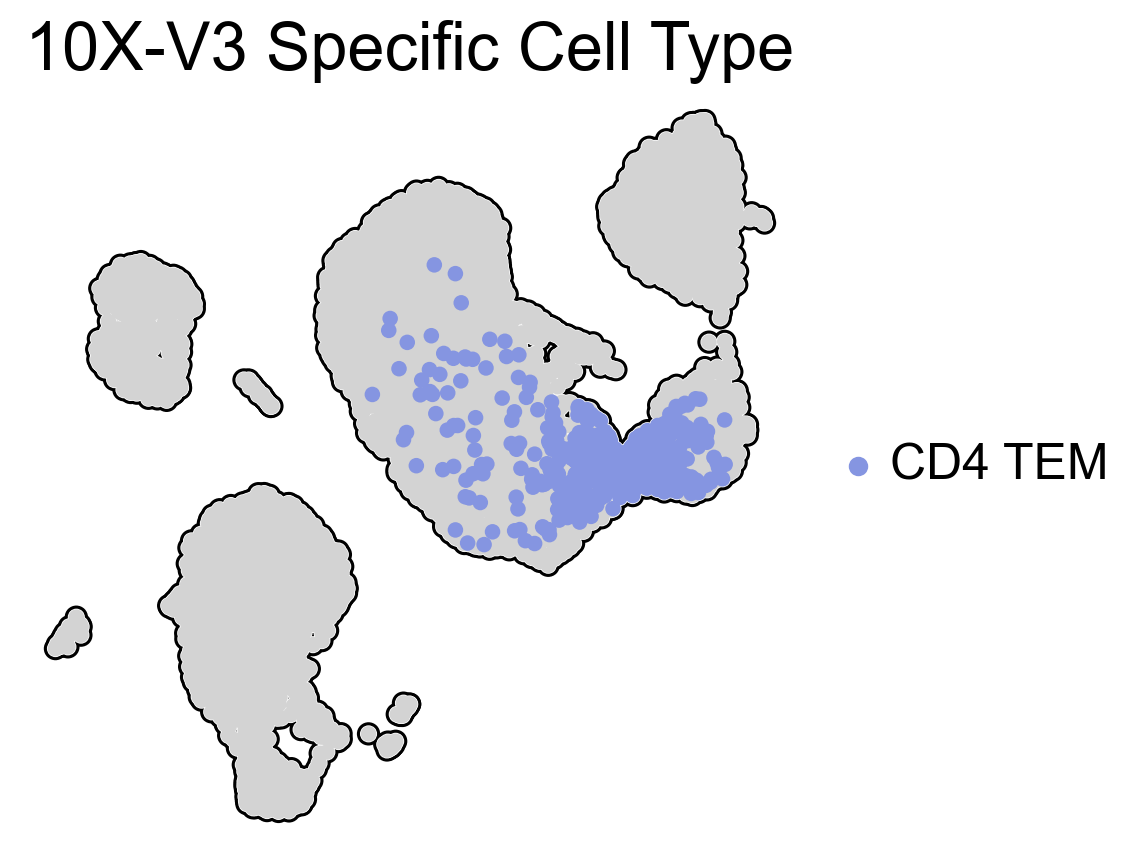

In [187]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.umap(adata,color=['Azimuth'], alpha=1,
                     frameon=False, title=f'10X-V3 Specific Cell Type', 
                     size=125, return_fig=False, add_outline=True, outline_width=(0.2, 0.05),
                     legend_loc='right margin', legend_fontsize=18, legend_fontoutline=2,
                     groups=unique_10x, na_in_legend=False,
                     save='PBMC_10xv3_Azimuth_unique_cells.png')

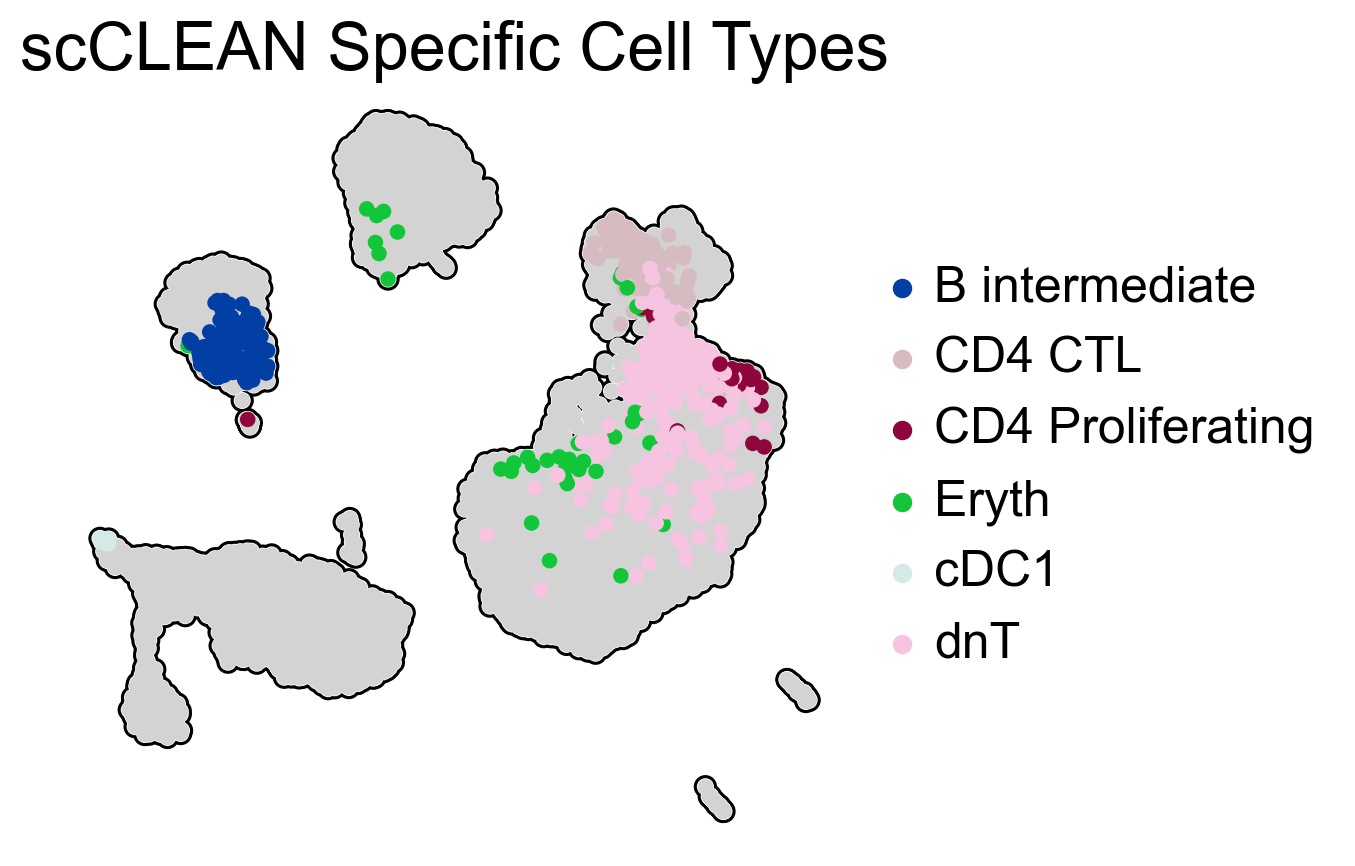

In [186]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.umap(data,color=['Azimuth'], alpha=1,
                     frameon=False, title=f'scCLEAN Specific Cell Types', 
                     size=125, return_fig=False, add_outline=True, outline_width=(0.2, 0.05),
                     legend_loc='right margin', legend_fontsize=18, legend_fontoutline=2,
                     groups=unique_scCLEAN, na_in_legend=False,
                     save='PBMC_scCLEAN_Azimuth_unique_cells.png')